In [ ]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('..'))

import random
from src import *

def coin(p: float) -> float:
    return 1 if random.random() < p else 0

In [14]:
def high_variance():
    if coin(0.5):
        return 10
    return -10

def low_variance():
    if coin(0.5):
        return 1
    return -1

program = Profile(Mul(Sampler(NamedCallable(lambda: high_variance(), "high_variance")), Add(Sampler(NamedCallable(lambda: low_variance(), "low_variance")), Exact(10))))

num_samples = 10000

print("Mean: ", Dist(program,num_samples).estimate(), "Variance: ", Dist(program.variance(),num_samples).estimate())
print("Summary:\n", program.summary())

Mean:  -0.238 Variance:  20012.64
Summary:
 ('high_variance', 28): (30000, 3.0361954122781755e-07)
('low_variance', 29): (30000, 2.987429965287447e-07)
('<function Sampler.variance.<locals>.<lambda> at 0x12c917600>', 30): (20000, 6.248512538149953e-07)
('<function Sampler.variance.<locals>.<lambda> at 0x12c917d80>', 31): (20000, 6.082014180719852e-07)



In [15]:
opt_bias = minimize_variance(program)
opt_bias

{'_bias_1600318_1': 0.98,
 '_bias_1600318_2': 0.02,
 '_bias_1600317': 0.9015609271827599}

In [16]:
no_bias_variance = program.variance()
bad_bias_variance = program.variance(adaptive=True)
good_bias_variance = program.variance(adaptive=True)

In [17]:
bad_bias = {env_var:0.5 for env_var in opt_bias}
no_bias_results = []
bad_bias_results = []
good_bias_results = []
for _ in range(10000):
    no_bias_results.append(no_bias_variance.estimate())
    bad_bias_results.append(bad_bias_variance.estimate(bad_bias))
    good_bias_results.append(good_bias_variance.estimate(opt_bias))

(array([5024.,    0.,    0.,    0.,    0.,    0., 1224., 1860.,  593.,
        1299.]),
 array([ -400.,  4680.,  9760., 14840., 19920., 25000., 30080., 35160.,
        40240., 45320., 50400.]),
 <BarContainer object of 10 artists>)

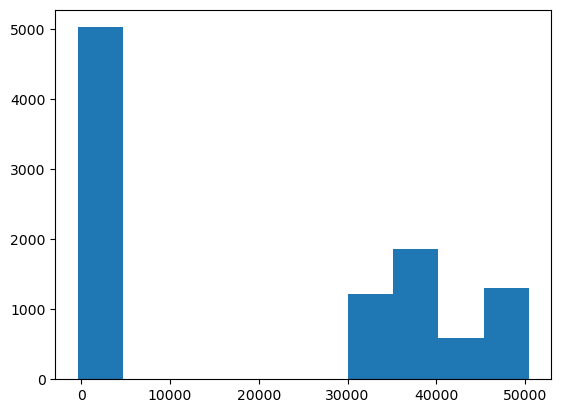

In [18]:
plt.hist(no_bias_results)

(array([8749.,    0.,    0.,    0.,    0.,    0.,  320.,    0.,  651.,
         280.]),
 array([ -3200.,  16480.,  36160.,  55840.,  75520.,  95200., 114880.,
        134560., 154240., 173920., 193600.]),
 <BarContainer object of 10 artists>)

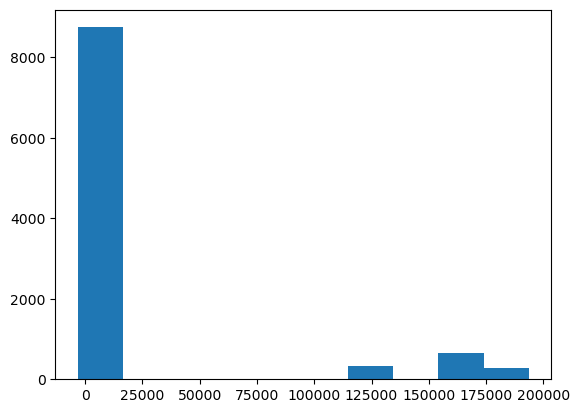

In [19]:
plt.hist(bad_bias_results)

(array([  45.,    0., 5068.,    0.,   43., 3583., 1201.,    0.,    0.,
          60.]),
 array([-22636.47708101, -11499.33035715,   -362.1836333 ,  10774.96309056,
         21912.10981442,  33049.25653827,  44186.40326213,  55323.54998599,
         66460.69670984,  77597.8434337 ,  88734.99015756]),
 <BarContainer object of 10 artists>)

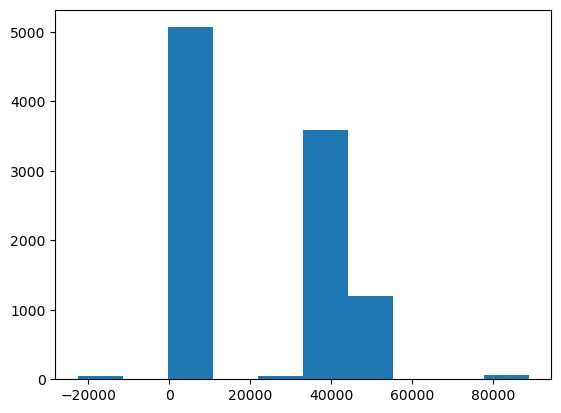

In [20]:
plt.hist(good_bias_results)

In [21]:
sum(no_bias_results)/10000, sum(bad_bias_results)/10000, sum(good_bias_results)/10000, 

(20363.84, 20280.8, 20456.74561928994)

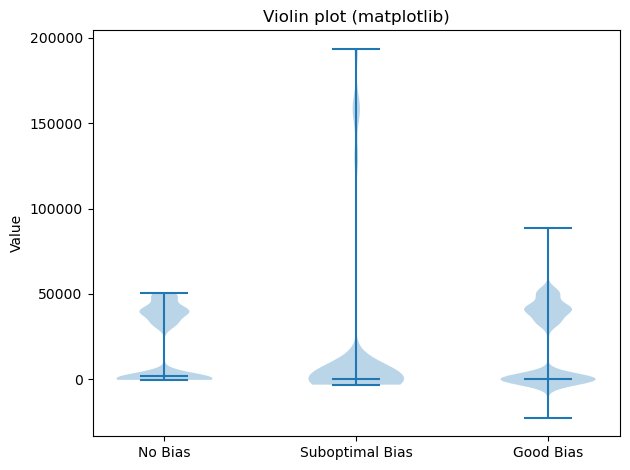

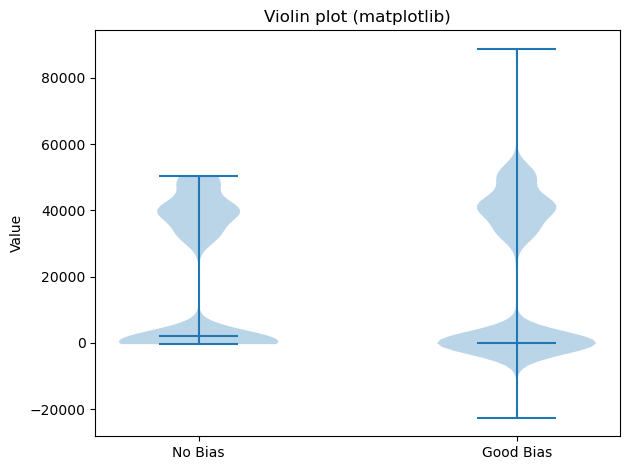

In [ ]:
data = [
    no_bias_results,
    bad_bias_results,
    good_bias_results,
]

fig, ax = plt.subplots()

parts = ax.violinplot(
    data,
    positions=np.arange(1, len(data) + 1),
    showmeans=False,
    showmedians=True,
    showextrema=True,
)

ax.set_xticks(np.arange(1, len(data) + 1))
ax.set_xticklabels(["No Bias", "Suboptimal Bias", "Good Bias"])
ax.set_ylabel("Variance")
ax.set_title("Violin plot")

plt.tight_layout()
plt.show()

data = [
    no_bias_results,
    good_bias_results,
]

fig, ax = plt.subplots()

parts = ax.violinplot(
    data,
    positions=np.arange(1, len(data) + 1),
    showmeans=False,
    showmedians=True,
    showextrema=True,
)

ax.set_xticks(np.arange(1, len(data) + 1))
ax.set_xticklabels(["No Bias", "Good Bias"])
ax.set_ylabel("Variance")
ax.set_title("Violin plot")

plt.tight_layout()
plt.show()


To explain a bit on why this is a great result:

When adaptive is set to True, the variance program evaluates Add by only evaluating one branch and appropriately scaling by the probability. This should, as we discussed in class. However, by biasing how often we go to either branch, we can "concentrate" samples to be in the branches that have higher variance. Indeed, the optimal biases demonstrate that behavior.